In [1]:
# pip install numpy

In [2]:
# pip install pandas

In [3]:
# pip install nnAudio

In [4]:
# pip install efficientnet

In [5]:
# pip install tensorflow

In [6]:
# pip install torch

In [57]:
# pip install scikit-plot

In [64]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

import torch
from nnAudio.Spectrogram import CQT1992v2

from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential, utils, optimizers, metrics
import tensorflow as tf
import tensorflow.keras.layers as layers
import keras

from sklearn.model_selection import train_test_split
from random import shuffle

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


from efficientnet.tfkeras import EfficientNetB0, EfficientNetB1

In [9]:
import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPUs:  0


2021-12-09 09:47:08.958184: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-12-09 09:47:08.958246: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: soet-gpu1
2021-12-09 09:47:08.958251: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: soet-gpu1
2021-12-09 09:47:08.958414: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.86.0
2021-12-09 09:47:08.958442: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.57.2
2021-12-09 09:47:08.958446: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.57.2 does not match DSO version 470.86.0 -- cannot find working devices in this configuration


In [10]:
import wandb
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: suhasgumma (use `wandb login --relogin` to force relogin)


In [11]:
#Function to get 3 signals in an np array from the given id.
#If Id 00001f4945 id is given, gets the np array of three signals from that id.
def getThreeSignalArray(identifier, isTrain):
    firstChar = identifier[0]
    secondChar = identifier[1]
    thirdChar = identifier[2]
    
    if isTrain:
        path = f'train/{firstChar}/{secondChar}/{thirdChar}/{identifier}.npy'
    
    else:
        path = f'test/{firstChar}/{secondChar}/{thirdChar}/{identifier}.npy'
    
    return np.load(path)
        
    

In [12]:
#Normalize the time series signals. Divide with the highest of the series. All values will fall under 0 and 1
def normalizeSignal(identifier, isTrain):
    threeSignals = getThreeSignalArray(identifier, isTrain)
    signal0 = threeSignals[0]
    signal1 = threeSignals[1]
    signal2 = threeSignals[2]
    
    signal0 = signal0/max(signal0)
    signal1 = signal0/max(signal1)
    signal2 = signal0/max(signal2)
    
    return threeSignals

In [13]:
#Visualise the data
#Selecting One with Signal --> Id: 'fac5791f7b'
#Selecting One without a signal --> Id: 'cd5e16350e'

In [14]:
targets = pd.read_csv("training_labels.csv")
y = targets["target"].values

all_identifiers = targets["id"].values
identifiers_1 = targets[targets["target"] == 1]["id"].values
identifiers_0 = targets[targets["target"] == 0]["id"].values


In [15]:
idWithSignal = '00000e74ad'
idWithoutSignal = '00001f4945'


In [16]:
def plotHStackSignalWithoutNormalizing(identifier, isTrain):
    threeSignalArray = getThreeSignalArray(identifier, isTrain)
    hStackedArray = np.hstack(threeSignalArray)
    
    plt.figure(figsize = (20,5))
    plt.plot(hStackedArray)
    
    plt.title(f"hstack of data {identifier} - {targets[targets['id'] == identifier].target.values}")
    

 

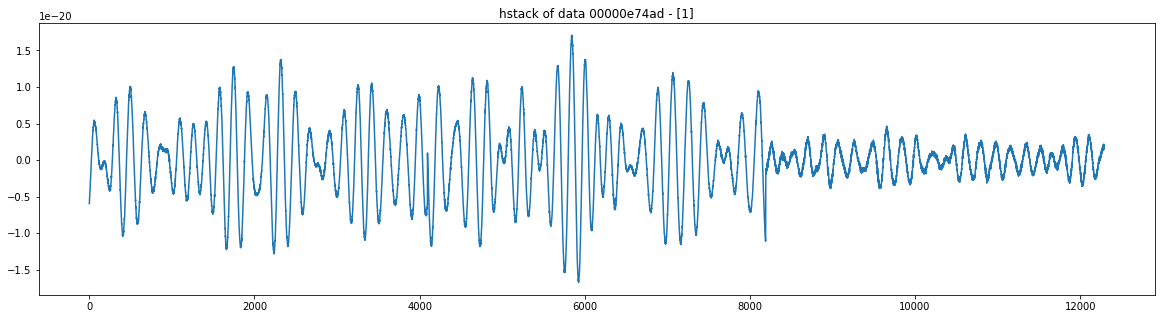

In [17]:
   
plotHStackSignalWithoutNormalizing(idWithSignal, True)


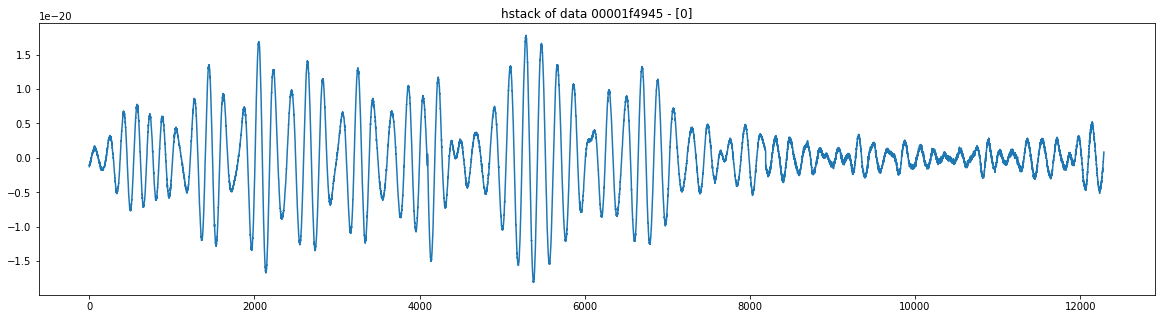

In [18]:
plotHStackSignalWithoutNormalizing(idWithoutSignal, True)

In [19]:
def plotHStackSignalWithNormalizing(identifier, isTrain):
    normalizedThreeSignalArray = normalizeSignal(identifier, isTrain)
    
    hStackedArray = np.hstack(normalizedThreeSignalArray)
    
    plt.figure(figsize = (20,5))
    plt.plot(hStackedArray)
    
    plt.title(f"hstack of data {identifier} - {targets[targets['id'] == identifier].target.values}")
    
    

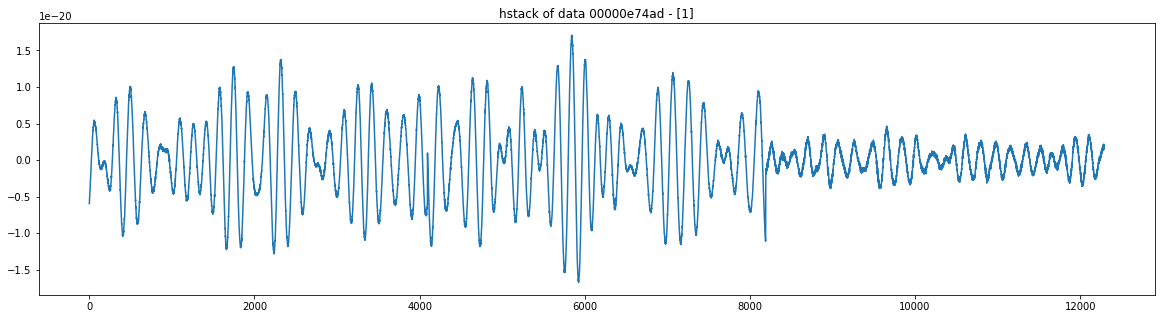

In [20]:
plotHStackSignalWithNormalizing(idWithSignal, True)


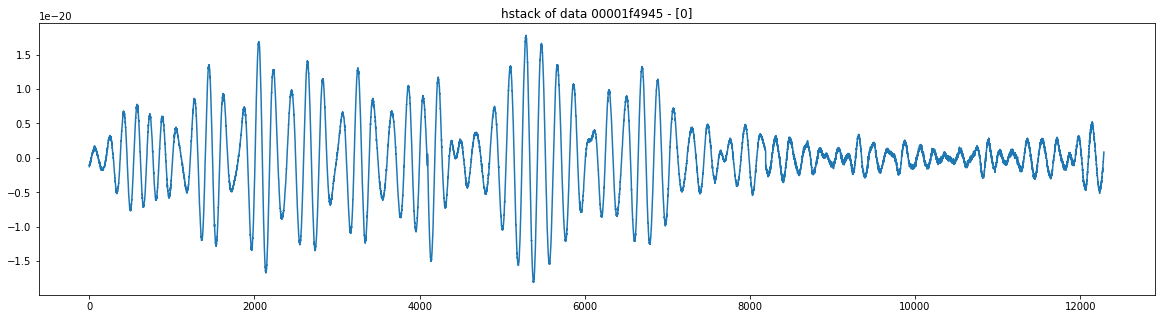

In [21]:
plotHStackSignalWithNormalizing(idWithoutSignal, True)

In [22]:
def plotDataParallely(identifier,isTrain):
    data = getThreeSignalArray(identifier, isTrain)
    plt.figure(figsize=(20,5))
    plt.plot(data[0], color="red", label="Detector 0")
    plt.plot(data[1], color="green", label="Detector 1")
    plt.plot(data[2], color="blue", label="Detector 2")
    plt.xlabel("sample")
    plt.ylabel("strain (m)")
    plt.legend()
    plt.title(f"data of each detector {identifier} - {targets[targets['id'] == identifier].target.values}")

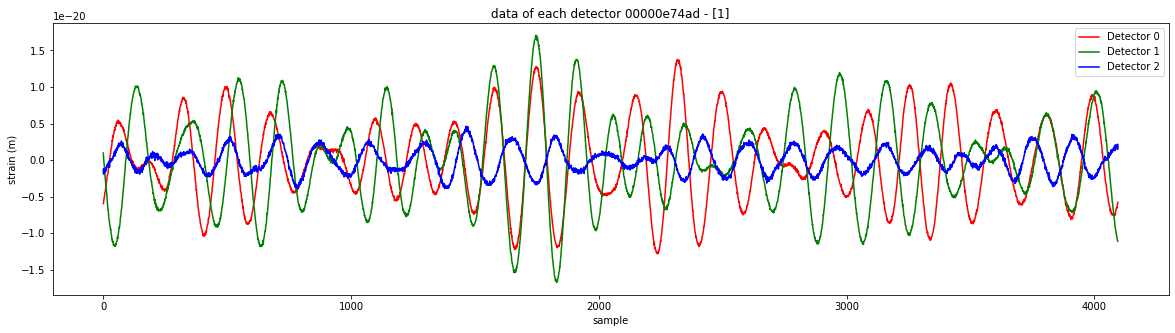

In [23]:
plotDataParallely(idWithSignal,True)

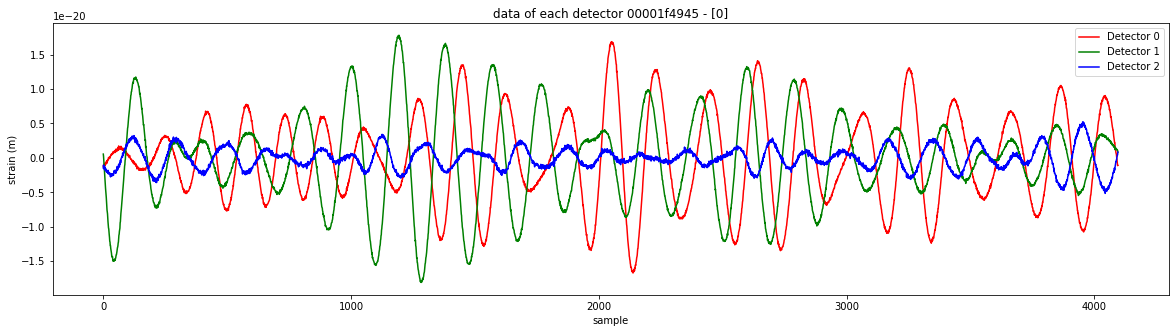

In [24]:
plotDataParallely(idWithoutSignal,True)

In [25]:
# CQT SPECTROGRAM

In [26]:
def getCQTSpectrogram(identifier, isTrain):
    cqt = CQT1992v2(sr=2048, hop_length=64, fmin=20, fmax=1024, bins_per_octave=12, norm=1, window='hann', center=True, pad_mode='reflect', trainable=False, output_format='Magnitude', verbose=False)
    
    waveform = np.hstack(getThreeSignalArray(identifier, isTrain))
    
    waveform = waveform / np.max(waveform)
    waveform = torch.from_numpy(waveform).float()
    cqt_image = cqt(waveform)
    cqt_image = np.array(cqt_image)
    
    cqt_image = np.transpose(cqt_image, (1,2,0))
    return cqt_image


In [27]:
def plotCQTSpectrogram(identifier, isTrain):
    image = getCQTSpectrogram(identifier, isTrain)
    plt.figure(figsize=(20,5))
    plt.imshow(image)
    plt.xlabel("scaled time")
    plt.ylabel("scaled frequency")
    plt.legend()
    plt.title(f"CQT1992 (nnAudio) spectrogram of hstack'd data {identifier} - {targets[targets['id'] == identifier].target.values}")

In [28]:
np.shape(getCQTSpectrogram(idWithSignal, True))

/home/suhas.gumma.17cse/.local/lib/python3.8/site-packages/nnAudio/utils.py:408: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


(69, 193, 1)

No handles with labels found to put in legend.


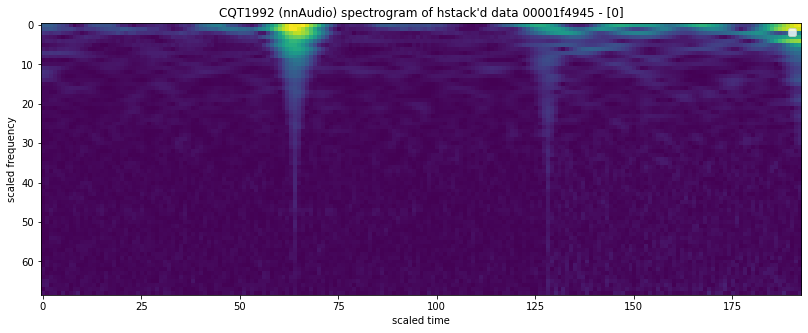

In [29]:
plotCQTSpectrogram(idWithoutSignal, True)

In [30]:
'0001016d12', '00010beb4a', '00025c4117.npy'

('0001016d12', '00010beb4a', '00025c4117.npy')

No handles with labels found to put in legend.


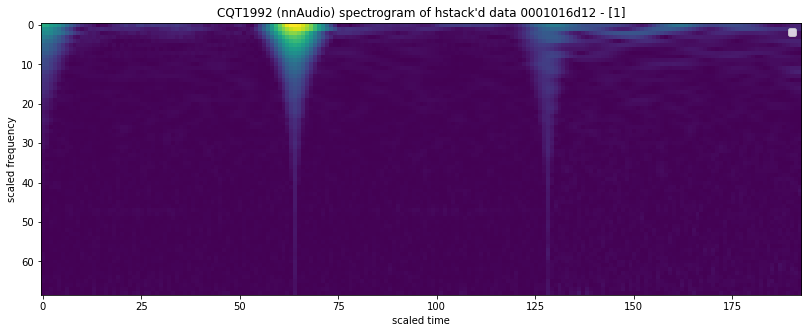

In [31]:
plotCQTSpectrogram('0001016d12', True)

No handles with labels found to put in legend.


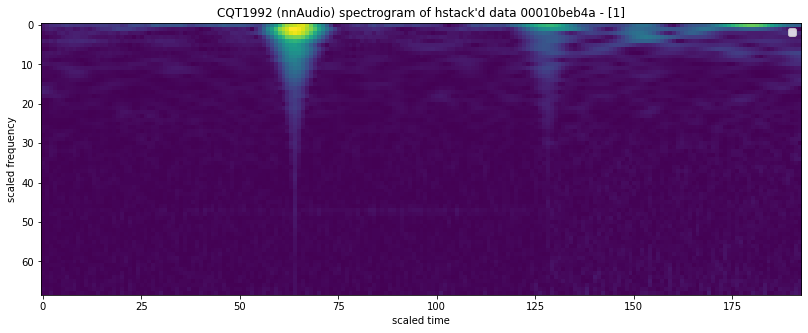

In [32]:
plotCQTSpectrogram('00010beb4a', True)

No handles with labels found to put in legend.


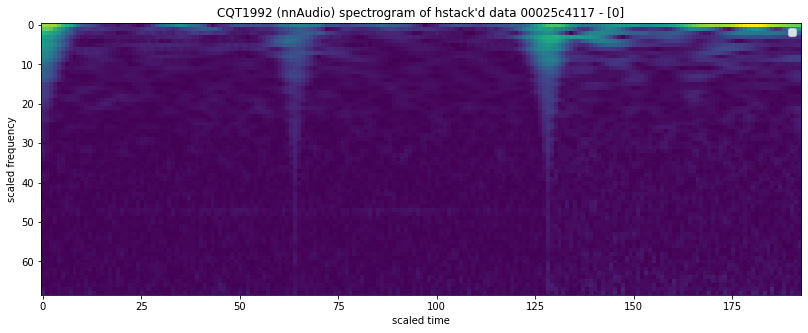

In [33]:
plotCQTSpectrogram('00025c4117', True)

In [34]:
class DataSetGenerator(Sequence):

    def get_sample(self, id, is_train):
        pass
    
    def __init__(self, identifiers, y=None, batch_size=256,
        shuffle=True, no_channels=10, no_classes=10, name="Unknown DataSet"):
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.identifiers = identifiers
        self.y = y
        self.name = name
        if y is not None:
            self.is_training = True
        else:
            self.is_training = False
        self.shape = self.get_sample(self.identifiers[0], self.is_training).shape
        print(f"{self.name} - Shape of each sample: {self.shape}\n")


    def __len__(self):
        return math.ceil(len(self.identifiers)/self.batch_size)

    def __getitem__(self, index):
        batch_ids = self.identifiers[index * self.batch_size:(index + 1) * self.batch_size]
        if self.y is not None:
            batch_y = self.y[index * self.batch_size: (index + 1) * self.batch_size]
        
        
        list_x = np.array([self.get_sample(x, self.is_training) for x in batch_ids])

        batch_X = np.stack(list_x)

        
        if self.is_training:
            return batch_X, batch_y
        else:
            return batch_X

    def on_epoch_end(self):
        if self.shuffle and self.is_training:
            ids_y = list(zip(self.identifiers, self.y))
            shuffle(ids_y)
            self.identifiers, self.y = list(zip(*ids_y))

In [35]:
class Cqt1992DataSetGenerator(DataSetGenerator):
    
    def get_sample(self, id, is_train):
        return getCQTSpectrogram(id, is_train)
    
    def __getitem__(self, index):
        batch_ids = self.identifiers[index * self.batch_size:(index + 1) * self.batch_size]
        if self.y is not None:
            batch_y = self.y[index * self.batch_size: (index + 1) * self.batch_size]

            
        list_x = np.array([self.get_sample(x, self.is_training) for x in batch_ids])
        
        
        batch_X = np.stack(list_x)

        if self.is_training:
            return batch_X, batch_y
        else:
            return batch_X

In [36]:
def get_cqt1992_model(shape):
    model = Sequential([
        layers.InputLayer(input_shape=(shape[0],shape[1],1)),
        layers.Conv2D(3,3,activation='relu',padding='same'),

        EfficientNetB1(include_top=False,input_shape=(),weights='imagenet'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(32,activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.summary()
    
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[metrics.AUC(), metrics.Precision(), metrics.Recall()])
    return model

In [37]:
targets = pd.read_csv("training_labels.csv")
sample_submission = pd.read_csv("sample_submission.csv")


test_identifiers = sample_submission["id"].values
identifiers = targets["id"].values
y = targets["target"].values




train_x, valid_x, train_y, valid_y = train_test_split(identifiers, y, train_size=0.95, random_state=42, stratify=y)




train_dataset = Cqt1992DataSetGenerator(train_x, train_y, batch_size=256, name="Training")
valid_dataset = Cqt1992DataSetGenerator(valid_x, valid_y, batch_size=256, name="Validation")
test_dataset = Cqt1992DataSetGenerator(test_identifiers, batch_size=256, name="Test")



sample_shape = train_dataset.shape


print("\n\n\n")


model = get_cqt1992_model(sample_shape)




callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    )
]

/home/suhas.gumma.17cse/.local/lib/python3.8/site-packages/nnAudio/utils.py:408: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)
2021-12-09 09:47:15.150621: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training - Shape of each sample: (69, 193, 1)

Validation - Shape of each sample: (69, 193, 1)

Test - Shape of each sample: (69, 193, 1)





Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 69, 193, 3)        30        
_________________________________________________________________
efficientnet-b1 (Functional) (None, None, None, 1280)  6575232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                40992     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 6,616,287
Trainable params: 6,554,239
Non-trainable params: 62,048
______________________________

In [38]:
model.load_weights('best_model.h5')

In [39]:
fitting = model.fit(train_dataset,validation_data=valid_dataset,epochs=1,
        verbose=1,callbacks = callbacks
    )



In [40]:
validationPredictions = model.predict(valid_dataset, verbose= 1)

print(validationPredictions)

110/110 [==============================] - 506s 5s/step
[[0.18103096]
 [0.30715734]
 [1.        ]
 ...
 [0.24790585]
 [0.4500682 ]
 [0.9864968 ]]


In [56]:
np.save('predictions.npy',validationPredictions )

In [107]:
modValidPreds = []
classifiedPreds = []

for pred in validationPredictions:
    modValidPreds.append(pred[0])
    classifiedPreds.append(0 if pred[0] < 0.5 else 1)
    

In [108]:
fpr, tpr, thresholds = metrics.roc_curve(valid_y, modValidPreds)


In [109]:
from sklearn.metrics import roc_auc_score
 
roc_auc = roc_auc_score(valid_y, modValidPreds)

print(roc_auc)

0.8520391231256428


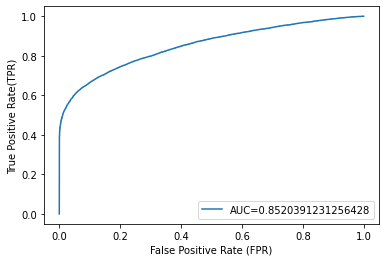

In [111]:

auc = metrics.roc_auc_score(valid_y, modValidPreds)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.show()

# plt.label("ROC Curve")


In [115]:
matrix = metrics.confusion_matrix(valid_y, classifiedPreds)

print(matrix)

[[ 9462  4542]
 [ 2642 11354]]
